In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-11-29 09:05:43.953368: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 09:05:43.953449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 09:05:43.953474: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 09:05:43.961526: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [5]:
# Load datasets
ppg_data_combined = pd.read_excel('combined_dataset.xlsx')

ppg_data_combined['Sex(M/F)'] = ppg_data_combined['Sex(M/F)'].map({'Male': 1, 'Female': 0})

print(ppg_data_combined)

     Num.  subject_ID  Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
0       1           2         0         45         152          63   
1       1           2         0         45         152          63   
2       1           2         0         45         152          63   
3       2           3         0         50         157          50   
4       2           3         0         50         157          50   
..    ...         ...       ...        ...         ...         ...   
652   218         418         1         25         173          63   
653   218         418         1         25         173          63   
654   219         419         1         24         175          58   
655   219         419         1         24         175          58   
656   219         419         1         24         175          58   

     Systolic Blood Pressure(mmHg)  Diastolic Blood Pressure(mmHg)  \
0                              161                              89   
1                  

In [6]:
# 참가자의 숫자 확인
print(ppg_data_combined['subject_ID'].nunique())

219


The dataset provided by Liang et al. in their study is a valuable resource for non-invasive CVD detection, encompassing 657 data segments from 219 individuals.

In [7]:
data_systolic = ppg_data_combined["Systolic Blood Pressure(mmHg)"]
data_diastolic = ppg_data_combined["Diastolic Blood Pressure(mmHg)"]
data_sex = ppg_data_combined["Sex(M/F)"]
data_age = ppg_data_combined["Age(year)"]
data_height = ppg_data_combined["Height(cm)"]
data_weight = ppg_data_combined["Weight(kg)"]
data_hr = ppg_data_combined["Heart Rate(b/m)"]
data_bmi = ppg_data_combined["BMI(kg/m^2)"]

ppg_data = ppg_data_combined.iloc[:,14:]

data_personal = pd.concat([data_sex, data_age, data_height, data_weight, data_hr, data_bmi], axis=1)

In [8]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data
scaler.fit(data_personal)

# Transform the data
normalized_data = scaler.transform(data_personal)

In [9]:
# Convert back to a DataFrame (optional, if you need the result as a DataFrame)
normalized_df = pd.DataFrame(normalized_data, columns=data_personal.columns)

ppg_data = np.array(ppg_data)
data_personal = np.array(normalized_df)
print(ppg_data)
print(data_personal)

[[2438 2438 2438 ... 1827 1754 1754]
 [2201 2201 2171 ... 1997 1997 1997]
 [2019 2014 2014 ... 1924 1929 1929]
 ...
 [3083 3039 3071 ... 2422 2451 2379]
 [2426 2431 2446 ... 3103 3146 3151]
 [2691 2718 2743 ... 2611 2639 2623]]
[[0.         0.36923077 0.1372549  0.40298507 0.83333333 0.55232326]
 [0.         0.36923077 0.1372549  0.40298507 0.83333333 0.55232326]
 [0.         0.36923077 0.1372549  0.40298507 0.83333333 0.55232326]
 ...
 [1.         0.04615385 0.58823529 0.32835821 0.24074074 0.18650234]
 [1.         0.04615385 0.58823529 0.32835821 0.24074074 0.18650234]
 [1.         0.04615385 0.58823529 0.32835821 0.24074074 0.18650234]]


In [10]:
# Assuming bp_data has columns 'systolic' and 'diastolic'
# Normalize blood pressure data
bp_data = np.array([data_systolic, data_diastolic]).T
print(bp_data)

[[161  89]
 [161  89]
 [161  89]
 ...
 [108  68]
 [108  68]
 [108  68]]


In [11]:
print(ppg_data.shape)
print(bp_data.shape)

(657, 2100)
(657, 2)


In [12]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(ppg_data, bp_data, test_size=0.2, random_state=42)

print("Train/Test Split:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Train/Test Split:
X_train shape: (525, 2100), y_train shape: (525, 2)
X_test shape: (132, 2100), y_test shape: (132, 2)


In [13]:
# Function to create sliding window data for LSTM
def create_sequence_data(X, y, time_steps=200, step=40):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps - 1])  # Use the last value in the window as the label
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # Decrease to allow sliding windows in test set
STEP = 5         # Small step size to maximize number of windows

# Create LSTM-compatible data
X_train_lstm, y_train_lstm = create_sequence_data(X_train, y_train, TIME_STEPS, STEP)
X_test_lstm, y_test_lstm = create_sequence_data(X_test, y_test, TIME_STEPS, STEP)

print("LSTM Data Shapes with Adjusted Parameters:")
print(f"X_train_lstm: {X_train_lstm.shape}, y_train_lstm: {y_train_lstm.shape}")
print(f"X_test_lstm: {X_test_lstm.shape}, y_test_lstm: {y_test_lstm.shape}")

LSTM Data Shapes with Adjusted Parameters:
X_train_lstm: (103, 10, 2100), y_train_lstm: (103, 2)
X_test_lstm: (25, 10, 2100), y_test_lstm: (25, 2)


In [14]:
def CWT_transform(data):
    images = []
    for signal in data:
        Wx, _ = cwt(signal, wavelet='morlet')  # Perform CWT
        Wx = np.abs(Wx)
        Wx = (Wx - Wx.min()) / (Wx.max() - Wx.min())  # Normalize
        images.append(Wx)

    # Ensure all samples have the same shape and convert to numpy array
    images = np.array(images)
    print(f"Shape of transformed data: {images.shape}")
    return images

# Perform CWT transform
X_train_cwt = CWT_transform(X_train)
X_test_cwt = CWT_transform(X_test)

# Add a channel dimension to make the data 3D (height, width, channels)
X_train_cwt = np.array([img[..., np.newaxis] for img in X_train_cwt])  # (246, 2100, 1)
X_test_cwt = np.array([img[..., np.newaxis] for img in X_test_cwt])    # (246, 2100, 1)

# Resize to (128, 128) for CNN input
X_train_cwt = np.array([tf.image.resize(img, [128, 128]).numpy() for img in X_train_cwt])
X_test_cwt = np.array([tf.image.resize(img, [128, 128]).numpy() for img in X_test_cwt])

# Ensure data shape is (samples, 128, 128, 1)
# Do NOT add an extra channel dimension here
print("Final CNN Data Shapes:")
print(f"X_train_cwt: {X_train_cwt.shape}, X_test_cwt: {X_test_cwt.shape}")

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Shape of transformed data: (525, 246, 2100)
Shape of transformed data: (132, 246, 2100)


2024-11-29 09:06:42.681236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:48:00.0, compute capability: 8.0
2024-11-29 09:06:42.683312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:8c:00.0, compute capability: 8.0


Final CNN Data Shapes:
X_train_cwt: (525, 128, 128, 1), X_test_cwt: (132, 128, 128, 1)


In [15]:
# Slice CNN data to match LSTM samples
X_train_cwt = X_train_cwt[:X_train_lstm.shape[0]]
X_test_cwt = X_test_cwt[:X_test_lstm.shape[0]]

# Debug final shapes
print("After Slicing:")
print(f"X_train_cwt shape: {X_train_cwt.shape}, X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")

After Slicing:
X_train_cwt shape: (103, 128, 128, 1), X_train_lstm shape: (103, 10, 2100)
y_train_lstm shape: (103, 2)


In [16]:
# # LSTM model for sequence data
# def create_lstm_model(input_shape):
#     model = Sequential([
#         layers.Input(shape=input_shape),
#         layers.LSTM(32, return_sequences=True),
#         layers.Dropout(0.3),
#         layers.LSTM(64, return_sequences=True),
#         layers.Dropout(0.3),
#         layers.LSTM(128, return_sequences=True),
#         layers.Dropout(0.3),
#         layers.LSTM(128),
#         layers.Dropout(0.3),
#         layers.Dense(128, activation='relu')
#     ])
#     return model

In [17]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [18]:
# Transformer Branch 수정
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.3,
    mlp_dropout=0.3,
):
    # 입력 이름을 명시적으로 설정
    inputs = keras.Input(shape=input_shape, name="Transformer_Input")
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    return inputs, x

In [19]:
# Combined CNN + Transformer Model
def build_combined_model(
    cnn_input_shape,
    transformer_input_shape,
    transformer_params,
    mlp_units,
    output_dim=2,  # For SBP and DBP
    dropout=0.25,
):
    # CNN Branch
    cnn_inputs = keras.Input(shape=cnn_input_shape, name="CNN_Input")
    x = layers.Conv2D(32, (3, 3), activation="relu")(cnn_inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    cnn_outputs = layers.Dense(128, activation="relu")(x)

    # Transformer Branch
    transformer_inputs, transformer_outputs = build_transformer_model(
        transformer_input_shape, **transformer_params, mlp_units=mlp_units
    )

    # Combine CNN and Transformer
    combined = layers.concatenate([cnn_outputs, transformer_outputs])
    x = layers.Dense(128, activation="relu")(combined)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(output_dim, activation="linear", name="BP_Output")(x)

    # Build and compile model
    model = Model(inputs=[cnn_inputs, transformer_inputs], outputs=outputs)
    return model

In [20]:
# Transformer Parameters
transformer_params = {
    "head_size": 64,
    "num_heads": 5,
    "ff_dim": 4,
    "num_transformer_blocks": 4,
    "dropout": 0.25,
    "mlp_dropout": 0.4,
}

# Input shapes
cnn_input_shape = (128, 128, 1)  # CNN input for CWT images
transformer_input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # Transformer input for LSTM-like sequence

# Build model
model = build_combined_model(
    cnn_input_shape,
    transformer_input_shape,
    transformer_params,
    mlp_units=[128],
    output_dim=2,  # For SBP and DBP
    dropout=0.25,
)

# Compile the model
model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["mse"]
)

# Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Transformer_Input (InputLa  [(None, 10, 2100)]           0         []                            
 yer)                                                                                             
                                                                                                  
 multi_head_attention (Mult  (None, 10, 2100)             2691060   ['Transformer_Input[0][0]',   
 iHeadAttention)                                                     'Transformer_Input[0][0]']   
                                                                                                  
 dropout (Dropout)           (None, 10, 2100)             0         ['multi_head_attention[0][0]']
                                                                                              

                                                                                                  
 tf.__operators__.add_5 (TF  (None, 10, 2100)             0         ['layer_normalization_5[0][0]'
 OpLambda)                                                          , 'tf.__operators__.add_4[0][0
                                                                    ]']                           
                                                                                                  
 multi_head_attention_3 (Mu  (None, 10, 2100)             2691060   ['tf.__operators__.add_5[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'tf.__operators__.add_5[0][0]
                                                                    ']                            
                                                                                                  
 dropout_6

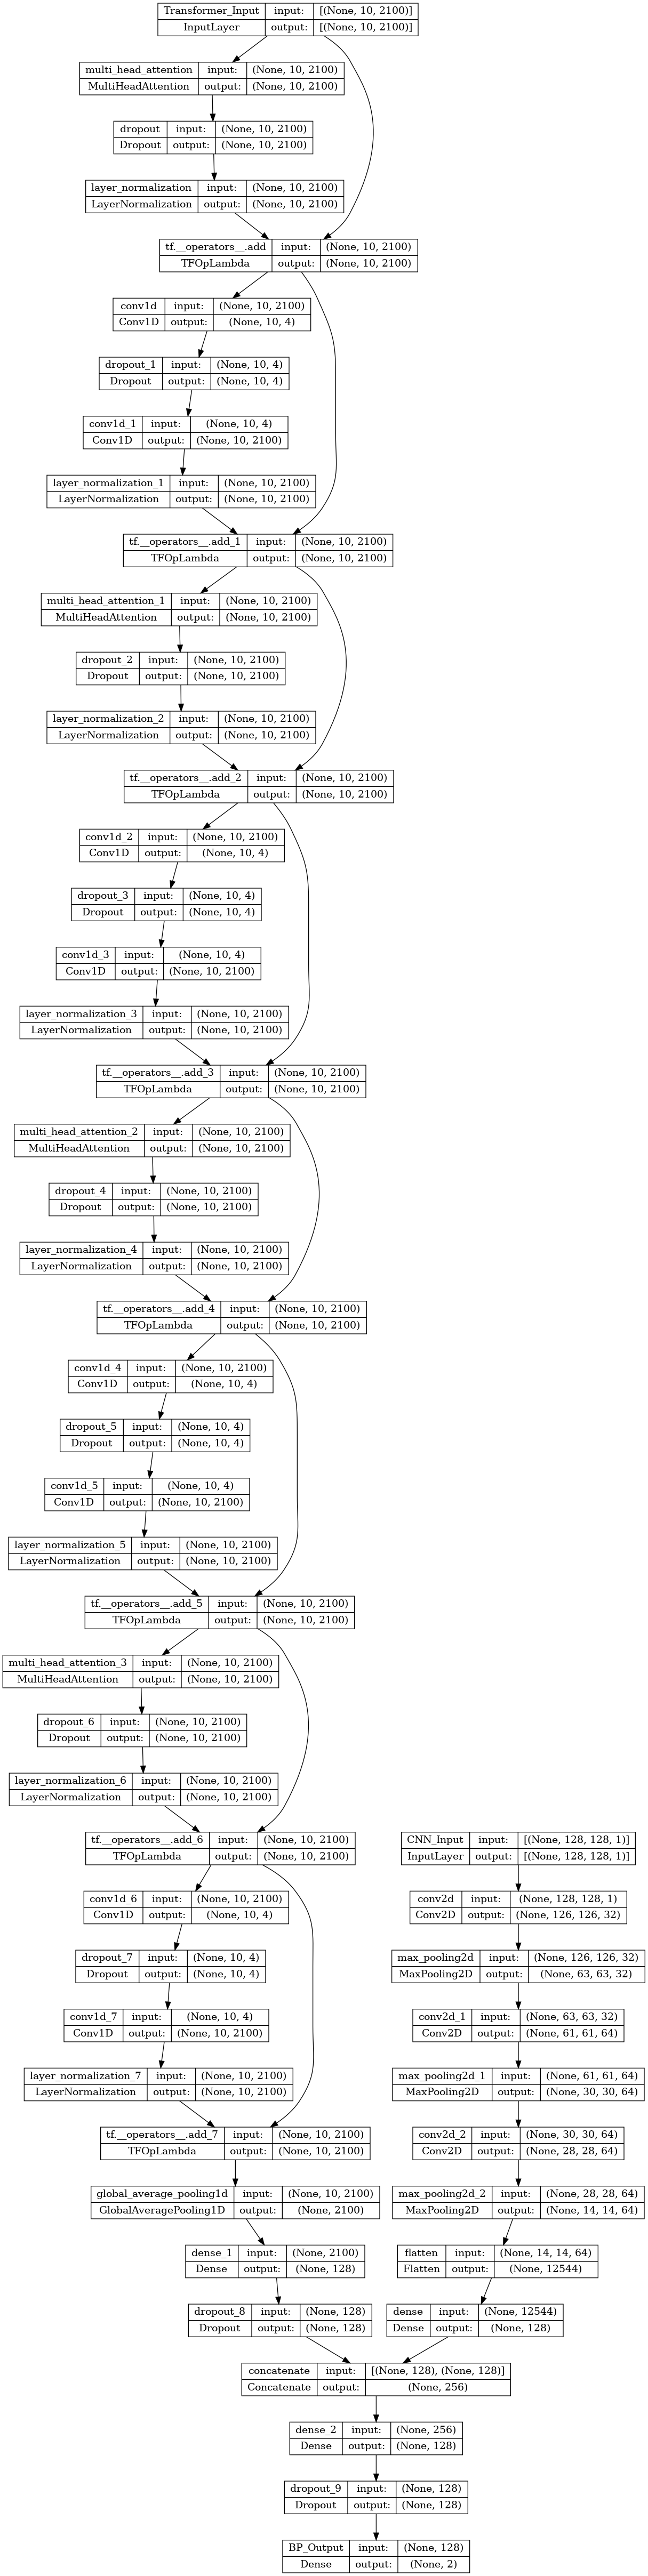

In [21]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping 설정
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# 모델 학습
history = model.fit(
    {"Transformer_Input": X_train_lstm, "CNN_Input": X_train_cwt},
    {"BP_Output": y_train_lstm},
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/500


2024-11-29 09:06:50.049116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-29 09:06:51.210149: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efdf8ce9a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-29 09:06:51.210210: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-11-29 09:06:51.210218: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-11-29 09:06:51.215410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-29 09:06:51.294775: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 [==============================] - 12s 487ms/step - loss: 2246274.2500 - mse: 2246274.2500 - val_loss: 303333.1875 - val_mse: 303333.1875
Epoch 2/500
3/3 [==============================] - 0s 132ms/step - loss: 1223475.7500 - mse: 1223475.7500 - val_loss: 111649.2344 - val_mse: 111649.2344
Epoch 3/500
3/3 [==============================] - 0s 60ms/step - loss: 853875.8750 - mse: 853875.8750 - val_loss: 48956.5859 - val_mse: 48956.5859
Epoch 4/500
3/3 [==============================] - 0s 56ms/step - loss: 638198.1250 - mse: 638198.1250 - val_loss: 31879.6973 - val_mse: 31879.6973
Epoch 5/500
3/3 [==============================] - 0s 58ms/step - loss: 388857.8438 - mse: 388857.8438 - val_loss: 3196.2534 - val_mse: 3196.2534
Epoch 6/500
3/3 [==============================] - 0s 45ms/step - loss: 246756.4375 - mse: 246756.4375 - val_loss: 6092.1035 - val_mse: 6092.1035
Epoch 7/500
3/3 [==============================] - 0s 42ms/step - loss: 129832.9375 - mse: 129832.9375 - val_loss: 60

3/3 [==============================] - 0s 39ms/step - loss: 538.6523 - mse: 538.6523 - val_loss: 301.7324 - val_mse: 301.7324
Epoch 59/500
3/3 [==============================] - 0s 52ms/step - loss: 565.4025 - mse: 565.4025 - val_loss: 277.7997 - val_mse: 277.7997
Epoch 60/500
3/3 [==============================] - 0s 56ms/step - loss: 700.7671 - mse: 700.7671 - val_loss: 264.7130 - val_mse: 264.7130
Epoch 61/500
3/3 [==============================] - 0s 55ms/step - loss: 562.1580 - mse: 562.1580 - val_loss: 263.6011 - val_mse: 263.6011
Epoch 62/500
3/3 [==============================] - 0s 39ms/step - loss: 666.2864 - mse: 666.2864 - val_loss: 270.8198 - val_mse: 270.8198
Epoch 63/500
3/3 [==============================] - 0s 48ms/step - loss: 603.1588 - mse: 603.1588 - val_loss: 280.5466 - val_mse: 280.5466
Epoch 64/500
3/3 [==============================] - 0s 42ms/step - loss: 611.4609 - mse: 611.4609 - val_loss: 291.2382 - val_mse: 291.2382
Epoch 65/500
3/3 [======================

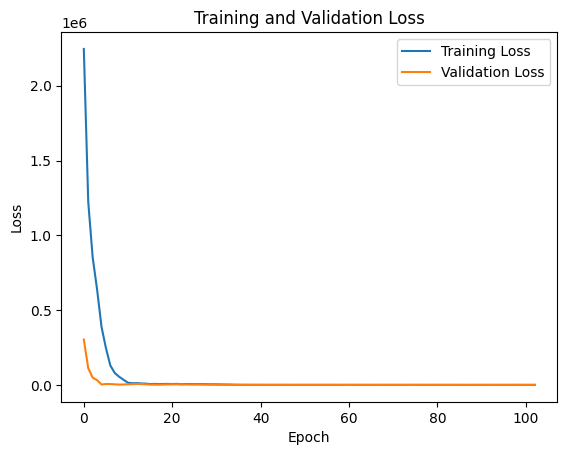

In [23]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [24]:
# Evaluate the model
test_loss, test_mae = model.evaluate(
    {"Transformer_Input": X_test_lstm, "CNN_Input": X_test_cwt},
    {"BP_Output": y_test_lstm}
)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


1/1 [==============================] - 0s 84ms/step - loss: 312.8908 - mse: 312.8908
Test Loss: 312.8907775878906, Test MAE: 312.8907775878906


1/1 [==============================] - 0s 410ms/step


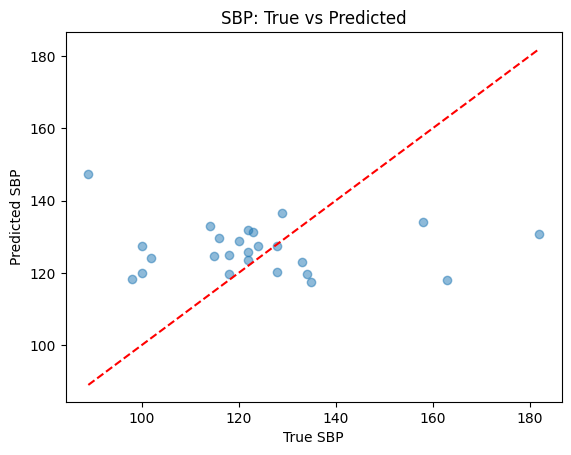

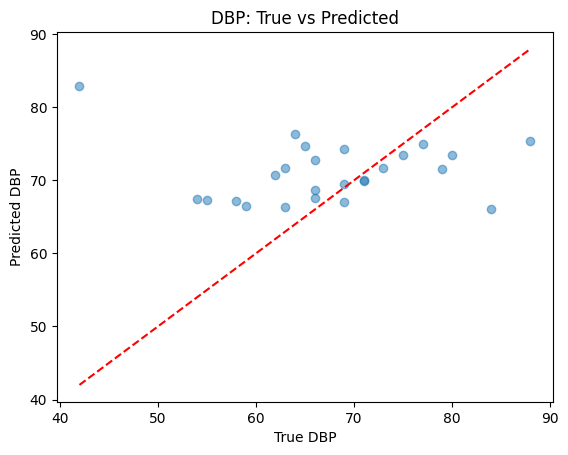

In [25]:
# Predict on test data
predictions = model.predict({"Transformer_Input": X_test_lstm, "CNN_Input": X_test_cwt})

# Compare predictions and true values
predicted_sbp = predictions[:, 0]
predicted_dbp = predictions[:, 1]
true_sbp = y_test_lstm[:, 0]
true_dbp = y_test_lstm[:, 1]

# Scatter plot
plt.scatter(true_sbp, predicted_sbp, alpha=0.5)
plt.plot([min(true_sbp), max(true_sbp)], [min(true_sbp), max(true_sbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True SBP')
plt.ylabel('Predicted SBP')
plt.title('SBP: True vs Predicted')
plt.show()

# Scatter plot for DBP
plt.scatter(true_dbp, predicted_dbp, alpha=0.5)
plt.plot([min(true_dbp), max(true_dbp)], [min(true_dbp), max(true_dbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True DBP')
plt.ylabel('Predicted DBP')
plt.title('DBP: True vs Predicted')
plt.show()



In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate SBP
mae_sbp = mean_absolute_error(true_sbp, predicted_sbp)
mse_sbp = mean_squared_error(true_sbp, predicted_sbp)
print(f"SBP - MAE: {mae_sbp}, MSE: {mse_sbp}")

# Evaluate DBP
mae_dbp = mean_absolute_error(true_dbp, predicted_dbp)
mse_dbp = mean_squared_error(true_dbp, predicted_dbp)
print(f"DBP - MAE: {mae_dbp}, MSE: {mse_dbp}")


SBP - MAE: 16.536670837402344, MSE: 496.2415033875755
DBP - MAE: 7.868648681640625, MSE: 129.54003113909624
